In [1]:
'''
author: Felix Hol
date: 2020 Oct 20
content: code to check presence of a mosquito in an (arbitrarly shaped) ROI
Takes tracked data from trackMosq as input and a mask indicating the ROI. 
'''

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import itertools as it
import pandas as pd
import pims
import skimage
from skimage import data, io, util
from skimage.measure import label, regionprops
from skimage.morphology import binary_dilation, erosion, dilation, opening, binary_closing, closing, white_tophat, remove_small_objects, disk, black_tophat, skeletonize, convex_hull_image
import scipy
import trackpy as tp
import pylab
import math
from joblib import Parallel, delayed
import multiprocessing
from datetime import datetime
from tqdm import tnrange, tqdm
import pickle
import glob
import cv2 as cv

In [66]:
#### set directories where to get images and where to store output, and specifics of experiment

# dataDir = '/run/user/1001/gvfs/smb-share:server=gaia.pasteur.fr,share=%40ivi/BITES_BLOOD_BEHAVIOR/P3/200923_KPPTN/ctrl02/'
# dataDir = '/mnt/DATA/biteData/P3/200930_KPPTN/denv04/'
saveDir = '/Users/felix/Documents/mosquitoes/mosquitoData/invitation/Analysis/3_primed/'
frames = pims.ImageSequence(saveDir+'/*.tiff')

In [3]:
os.chdir(saveDir)

In [39]:
trackPickleName = '/Users/felix/Documents/mosquitoes/mosquitoData/biteData/aegypti/190625_KPPTN/190625_KPPTN_01_tracks.pkl'
tFull = pd.read_pickle(trackPickleName)

In [40]:
#### read image containing mask - maks can e.g. be made in ImageJ 
#### by drawing with freehand tool and using 'edit' -> 'clear outside'

masks = pims.ImageSequence(saveDir+'/*.png')

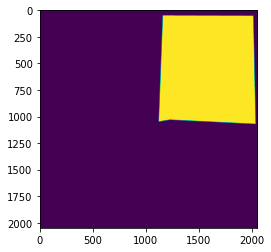

In [12]:
plt.imshow(skimage.transform.rotate(masks[0], 90))

In [35]:
maskP = masks[0]
maskC1 = cv.rotate(maskP, cv.ROTATE_90_CLOCKWISE)
maskC2 = cv.rotate(maskP, cv.ROTATE_180)
maskC3 = cv.rotate(maskP, cv.ROTATE_90_COUNTERCLOCKWISE)

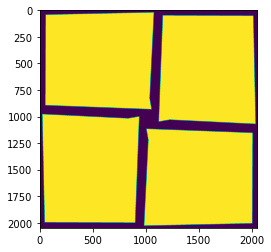

In [38]:
### Check if there is considerable overlap between ROIs. If there is, you're in trouble. 
plt.imshow(maskC3 + maskC1 + maskC2 + maskP)

In [37]:
cntsP, hierarchyP = cv.findContours(maskP, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cntsC1, hierarchyC1 = cv.findContours(maskC1, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cntsC2, hierarchyC2 = cv.findContours(maskC2, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cntsC3, hierarchyC3 = cv.findContours(maskC3, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

In [58]:
tROI = tFull.copy()
tROI['roi'] = np.nan

### ROI column: labeled 1, coordinate is in primed ROI, labeled 2-4: coord is in control region 1, 2, 3. Labeled 0: in none of the ROIs. 

for index, row in tqdm(tROI.iterrows()):
    if cv.pointPolygonTest(cntsP[0], (row.x, row.y), False) == 1.0:
        tROI.loc[index, 'roi'] = 1
    elif cv.pointPolygonTest(cntsC1[0], (row.x, row.y), False) == 1.0:
        tROI.loc[index, 'roi'] = 2
    elif cv.pointPolygonTest(cntsC2[0], (row.x, row.y), False) == 1.0:
        tROI.loc[index, 'roi'] = 3
    elif cv.pointPolygonTest(cntsC3[0], (row.x, row.y), False) == 1.0:
        tROI.loc[index, 'roi'] = 4
    else:
        tROI.loc[index, 'roi'] = 0
            
            


59304it [00:15, 3830.16it/s]


In [60]:
tROI.head()

,y,x,frame,particle,roi
0,0.000000,0.000000,0.0,0.0,0.0
1,1864.008150,1463.219517,423.0,1.0,1.0
2,1591.277796,1324.646135,424.0,1.0,1.0
3,1970.678214,1189.911364,425.0,1.0,1.0
4,1992.718723,1180.756103,426.0,1.0,1.0


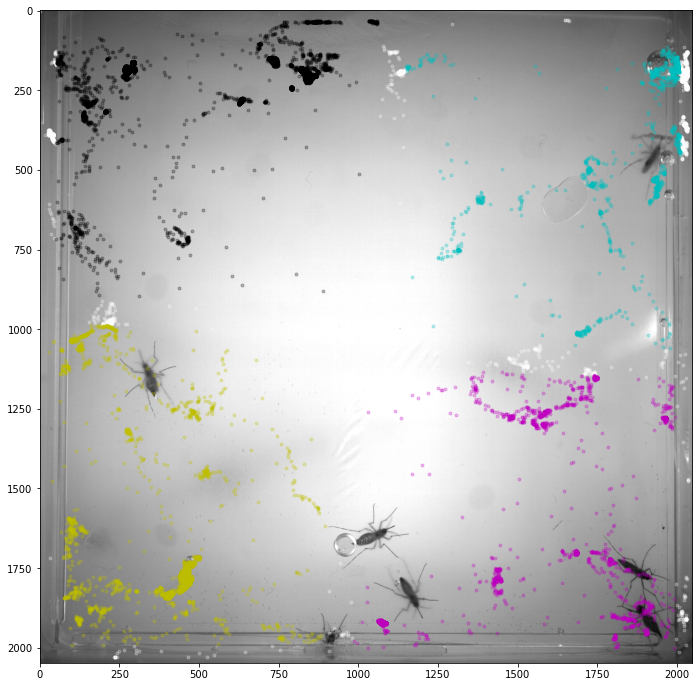

In [68]:
plt.figure(figsize=(18,12))
plt.imshow(frames[2], cmap = 'gray')
plt.plot(tROI.loc[tROI['roi'] == 0].x, tROI.loc[tROI['roi'] == 0].y,'w.', alpha=0.25)
plt.plot(tROI.loc[tROI['roi'] == 1].x, tROI.loc[tROI['roi'] == 1].y,'m.', alpha=0.25)
plt.plot(tROI.loc[tROI['roi'] == 2].x, tROI.loc[tROI['roi'] == 2].y,'y.', alpha=0.25)
plt.plot(tROI.loc[tROI['roi'] == 3].x, tROI.loc[tROI['roi'] == 3].y,'k.', alpha=0.25)
plt.plot(tROI.loc[tROI['roi'] == 4].x, tROI.loc[tROI['roi'] == 4].y,'c.', alpha=0.25)

In [70]:
len(tROI.loc[tROI['roi'] == 1]) / np.sum(maskP>0)

0.005083638279408528

In [72]:
len(tROI.loc[tROI['roi'] == 2]) / np.sum(maskP>0)

0.017692384007407653

In [73]:
len(tROI.loc[tROI['roi'] == 3]) / np.sum(maskP>0)

0.03406653431113736

In [74]:
len(tROI.loc[tROI['roi'] == 4]) / np.sum(maskP>0)

0.0017002477960067553